In [6]:
!pip install tenserflow

ERROR: Could not find a version that satisfies the requirement tenserflow (from versions: none)
ERROR: No matching distribution found for tenserflow


In [1]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from pathlib import Path
from warnings import filterwarnings

from rdkit.Chem import Draw, PandasTools
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer



### **Target search for Acetylcholinesterase**

In [17]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('aromatase')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[0]
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,None,None,CHEMBL1133116,J Med Chem,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,None,CHEMBL341591,5.15,0,http://www.openphacts.org/units/Nanomolar,267172,=,1,1,=,None,IC50,nM,None,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,None,None,CHEMBL1133116,J Med Chem,2000.0,None,CHEMBL2111947,None,CHEMBL2111947,None,0,http://www.openphacts.org/units/Nanomolar,267163,>,1,1,>,None,IC50,nM,None,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,None,None,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,None,CHEMBL431859,6.62,0,http://www.openphacts.org/units/Nanomolar,214178,=,1,1,=,None,IC50,nM,None,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238
3,None,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,None,CHEMBL113637,7.24,0,http://www.openphacts.org/units/Nanomolar,214179,=,1,1,=,None,IC50,nM,None,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.057
4,None,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,None,None,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,None,CHEMBL112021,7.27,0,http://www.openphacts.org/units/Nanomolar,214173,=,1,1,=,None,IC50,nM,None,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,None,24377182,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,None,None,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '16.56', 'le': '0.30', 'lle': '0.54', ...",CHEMBL5092843,None,CHEMBL5092843,5.49,0,http://www.openphacts.org/units/Nanomolar,3776554,=,1,1,=,None,IC50,nM,None,3240.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,3.24
2922,None,24377183,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)

We will assign the first entry (which corresponds to the target protein, Human Acetylcholinesterase) to the selected_target variable

In [14]:
df=pd.set_option('display.max_columns',45)

In [19]:
df.to_csv('VersionBrute.csv', index=False)

In [20]:
df = pd.read_csv('VersionBrute.csv')

# Show None Columns

In [21]:
all_none_columns = []
for col in df.columns:
    if df[col].isnull().all():
        all_none_columns.append(col)

# Print the names of the columns that have all None values
print('Columns with all None values:', all_none_columns)

Columns with all None values: ['assay_variant_accession', 'assay_variant_mutation', 'standard_text_value', 'standard_upper_value', 'text_value', 'toid', 'upper_value']


In [22]:
df.standard_upper_value

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2921   NaN
2922   NaN
2923   NaN
2924   NaN
2925   NaN
Name: standard_upper_value, Length: 2926, dtype: float64

In [23]:
df.standard_upper_value.unique()

array([nan])

In [24]:
df.target_chembl_id

0       CHEMBL1978
1       CHEMBL1978
2       CHEMBL1978
3       CHEMBL1978
4       CHEMBL1978
           ...    
2921    CHEMBL1978
2922    CHEMBL1978
2923    CHEMBL1978
2924    CHEMBL1978
2925    CHEMBL1978
Name: target_chembl_id, Length: 2926, dtype: object

In [25]:
df.target_chembl_id.unique()

array(['CHEMBL1978'], dtype=object)

In [26]:
df.target_tax_id.unique()

array([9606], dtype=int64)

In [27]:
df.target_organism

0       Homo sapiens
1       Homo sapiens
2       Homo sapiens
3       Homo sapiens
4       Homo sapiens
            ...     
2921    Homo sapiens
2922    Homo sapiens
2923    Homo sapiens
2924    Homo sapiens
2925    Homo sapiens
Name: target_organism, Length: 2926, dtype: object

In [28]:
df.target_pref_name

0       Cytochrome P450 19A1
1       Cytochrome P450 19A1
2       Cytochrome P450 19A1
3       Cytochrome P450 19A1
4       Cytochrome P450 19A1
                ...         
2921    Cytochrome P450 19A1
2922    Cytochrome P450 19A1
2923    Cytochrome P450 19A1
2924    Cytochrome P450 19A1
2925    Cytochrome P450 19A1
Name: target_pref_name, Length: 2926, dtype: object

# Remove None Columns

In [29]:
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df = df[df.units.notna()]
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,NaN,CHEMBL341591,5.15,0,http://www.openphacts.org/units/Nanomolar,267172,=,1,1,=,NaN,IC50,nM,NaN,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,7.100
1,NaN,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,NaN,CHEMBL2111947,NaN,CHEMBL2111947,NaN,0,http://www.openphacts.org/units/Nanomolar,267163,>,1,1,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.000
2,NaN,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,NaN,CHEMBL431859,6.62,0,http://www.openphacts.org/units/Nanomolar,214178,=,1,1,=,NaN,IC50,nM,NaN,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.238
3,NaN,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,NaN,CHEMBL113637,7.24,0,http://www.openphacts.org/units/Nanomolar,214179,=,1,1,=,NaN,IC50,nM,NaN,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.057
4,NaN,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,NaN,CHEMBL112021,7.27,0,http://www.openphacts.org/units/Nanomolar,214173,=,1,1,=,NaN,IC50,nM,NaN,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,NaN,24377182,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '16.56', 'le': '0.30', 'lle': '0.54', ...",CHEMBL5092843,NaN,CHEMBL5092843,5.49,0,http://www.openphacts.org/units/Nanomolar,3776554,=,1,1,=,NaN,IC50,nM,NaN,3240.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.240
2922,NaN,24377183,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '

In [30]:
#Remove duplicated values
df = df.drop_duplicates(['canonical_smiles'])
df 

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,NaN,CHEMBL341591,5.15,0,http://www.openphacts.org/units/Nanomolar,267172,=,1,1,=,NaN,IC50,nM,NaN,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,7.100
1,NaN,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,NaN,CHEMBL2111947,NaN,CHEMBL2111947,NaN,0,http://www.openphacts.org/units/Nanomolar,267163,>,1,1,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.000
2,NaN,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,NaN,CHEMBL431859,6.62,0,http://www.openphacts.org/units/Nanomolar,214178,=,1,1,=,NaN,IC50,nM,NaN,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.238
3,NaN,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,NaN,CHEMBL113637,7.24,0,http://www.openphacts.org/units/Nanomolar,214179,=,1,1,=,NaN,IC50,nM,NaN,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.057
4,NaN,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,NaN,CHEMBL112021,7.27,0,http://www.openphacts.org/units/Nanomolar,214173,=,1,1,=,NaN,IC50,nM,NaN,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,NaN,24377180,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '19.58', 'le': '0.36', 'lle': '2.18', ...",CHEMBL5087363,NaN,CHEMBL5087363,6.00,0,http://www.openphacts.org/units/Nanomolar,3776552,=,1,1,=,NaN,IC50,nM,NaN,1002.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.002
2920,NaN,24377181,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '17.5

In [31]:
#Pourcentage des valeurs null
(df.isnull().sum()/df.shape[0])*100

activity_comment             100.000000
activity_id                    0.000000
activity_properties            0.000000
assay_chembl_id                0.000000
assay_description              0.000000
assay_type                     0.000000
assay_variant_accession      100.000000
assay_variant_mutation       100.000000
bao_endpoint                   0.000000
bao_format                     0.000000
bao_label                      0.000000
canonical_smiles               0.000000
data_validity_comment         97.185832
data_validity_description     97.185832
document_chembl_id             0.000000
document_journal               0.145560
document_year                  0.145560
ligand_efficiency             14.410480
molecule_chembl_id             0.000000
molecule_pref_name            94.468705
parent_molecule_chembl_id      0.000000
pchembl_value                 13.440078
potential_duplicate            0.000000
qudt_units                     0.000000
record_id                      0.000000


In [33]:
df.to_csv('aromatase2.csv', index=False)

In [34]:
df2 = pd.read_csv('aromatase2.csv')

In [35]:
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,"{'bei': '15.62', 'le': '0.29', 'lle': '0.86', ...",CHEMBL341591,NaN,CHEMBL341591,5.15,0,http://www.openphacts.org/units/Nanomolar,267172,=,1,1,=,NaN,IC50,nM,NaN,7100.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,7.100
1,NaN,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,NaN,NaN,CHEMBL1133116,J Med Chem,2000.0,NaN,CHEMBL2111947,NaN,CHEMBL2111947,NaN,0,http://www.openphacts.org/units/Nanomolar,267163,>,1,1,>,NaN,IC50,nM,NaN,50000.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.000
2,NaN,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '16.06', 'le': '0.35', 'lle': '0.91', ...",CHEMBL431859,NaN,CHEMBL431859,6.62,0,http://www.openphacts.org/units/Nanomolar,214178,=,1,1,=,NaN,IC50,nM,NaN,238.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.238
3,NaN,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.68', 'le': '0.41', 'lle': '2.61', ...",CHEMBL113637,NaN,CHEMBL113637,7.24,0,http://www.openphacts.org/units/Nanomolar,214179,=,1,1,=,NaN,IC50,nM,NaN,57.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.057
4,NaN,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,NaN,NaN,CHEMBL1131917,Bioorg Med Chem Lett,1999.0,"{'bei': '22.58', 'le': '0.43', 'lle': '2.68', ...",CHEMBL112021,NaN,CHEMBL112021,7.27,0,http://www.openphacts.org/units/Nanomolar,214173,=,1,1,=,NaN,IC50,nM,NaN,54.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,NaN,24377180,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '19.58', 'le': '0.36', 'lle': '2.18', ...",CHEMBL5087363,NaN,CHEMBL5087363,6.00,0,http://www.openphacts.org/units/Nanomolar,3776552,=,1,1,=,NaN,IC50,nM,NaN,1002.0,CHEMBL1978,Homo sapiens,Cytochrome P450 19A1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.002
2057,NaN,24377181,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5037521,Inhibition of human aromatase assessed as redu...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,NaN,NaN,CHEMBL5036334,Eur J Med Chem,2021.0,"{'bei': '17.5

# Exploration

In [39]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df2['canonical_smiles']]
df2['num_atoms'] = [Descriptors.HeavyAtomCount(mol) for mol in mols]
df2['num_rings'] = [Descriptors.RingCount(mol) for mol in mols]
df2['NumValenceElectron'] = [Descriptors.NumValenceElectrons(mol) for mol in mols]
df2['NumAliphaticCarbocycles '] = [Descriptors.NumAliphaticCarbocycles(mol) for mol in mols]
df2['NumSaturatedRings'] = [Descriptors.NumSaturatedRings(mol) for mol in mols]
df2['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(mol) for mol in mols]
df2['NumHeteroatoms'] = [Descriptors.NumHeteroatoms(mol) for mol in mols]
df2['TPSA'] = [Descriptors.TPSA(mol) for mol in mols]




In [40]:
df_selected = df2[['molecule_chembl_id','canonical_smiles','standard_value','num_atoms','num_rings','NumHeteroatoms','num_atoms','num_rings','NumValenceElectron','NumAliphaticCarbocycles ','NumSaturatedRings','NumRotatableBonds',]]

In [41]:
df_selected

,molecule_chembl_id,canonical_smiles,standard_value,num_atoms,num_rings,NumHeteroatoms,num_atoms,num_rings,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0,24,5,2,24,5,134,4,4,2
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.0,23,5,2,23,5,128,4,4,1
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0,26,4,5,26,4,132,0,0,4
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0,24,4,4,24,4,120,0,0,4
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0,23,4,4,23,4,114,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,1002.0,23,3,4,23,3,116,0,0,4
2057,CHEMBL5092560,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,900.0,26,3,3,26,3,132,0,0,6
2058,CHEMBL5092843,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,3240.0,25,3,3,25,3,126,0,0,5
2059,CHEMBL5074047,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,52.0,25,3,4,25,3,128,0,0,6


# Add Class for standard_value 

### **Labeling compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [42]:
Class = []
for i in df_selected.standard_value:
  if float(i) >= 10000:
    Class.append("inactive")
  elif float(i) <= 1000:
    Class.append("active")
  else:
    Class.append("intermediate")

In [43]:
bioactivity_class = pd.Series(Class, name='Class')
df3= pd.concat([df_selected, bioactivity_class], axis=1, join='inner')
df3

,molecule_chembl_id,canonical_smiles,standard_value,num_atoms,num_rings,NumHeteroatoms,num_atoms,num_rings,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0,24,5,2,24,5,134,4,4,2,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.0,23,5,2,23,5,128,4,4,1,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0,26,4,5,26,4,132,0,0,4,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0,24,4,4,24,4,120,0,0,4,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0,23,4,4,23,4,114,0,0,4,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,1002.0,23,3,4,23,3,116,0,0,4,intermediate
2057,CHEMBL5092560,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,900.0,26,3,3,26,3,132,0,0,6,active
2058,CHEMBL5092843,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,3240.0,25,3,3,25,3,126,0,0,5,intermediate
2059,CHEMBL5074047,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,52.0,25,3,4,25,3,128,0,0,6,active


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

all numbers are multiples of five, which is the origin of the rule's name

In [44]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [45]:
df_lipinski = lipinski(df3.canonical_smiles)

In [46]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,329.528,4.28820,2.0,2.0
1,315.501,3.89810,2.0,2.0
2,412.306,5.70542,0.0,3.0
3,319.383,4.63450,0.0,3.0
4,321.811,4.58780,0.0,3.0
...,...,...,...,...
2056,306.365,3.81630,2.0,4.0
2057,345.442,5.33750,2.0,3.0
2058,331.415,4.94740,2.0,3.0
2059,334.419,4.66560,3.0,3.0


In [47]:
df_combined = pd.concat([df3,df_lipinski], axis=1)

In [48]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,num_atoms,num_rings,NumHeteroatoms,num_atoms,num_rings,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.0,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,1002.0,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0
2057,CHEMBL5092560,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,900.0,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0
2058,CHEMBL5092843,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,3240.0,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0
2059,CHEMBL5074047,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,52.0,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0


In [365]:
#list=['molecule_chembl_id','canonical_smiles','standard_value','MW','LogP','NumHDonors','NumHAcceptors','Class']

In [366]:
#df_columns = df_combined.reindex(columns=swap_list)

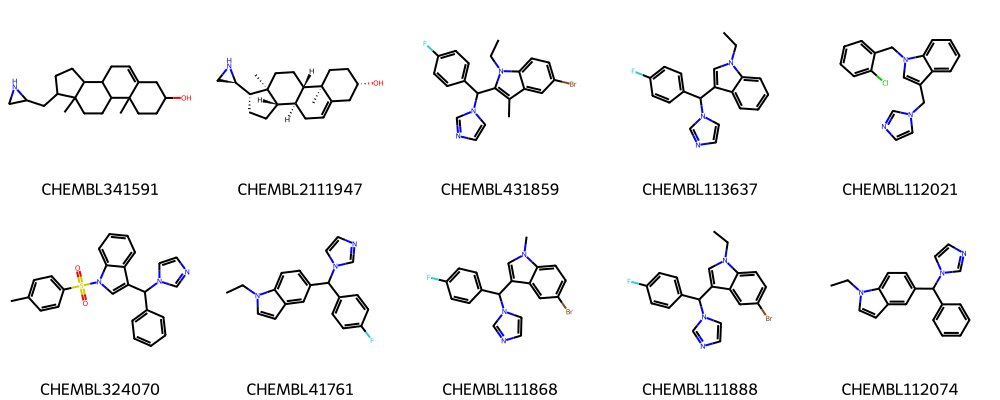

In [49]:
# Using PandasTools and the respective Draw method
PandasTools.AddMoleculeColumnToFrame(df_combined, smilesCol="canonical_smiles", molCol="Mol2D")
Draw.MolsToGridImage(list(df_combined.Mol2D[0:10]), legends=list(df_combined.molecule_chembl_id[0:20]), molsPerRow=5)

In [50]:
df6=df_combined

In [51]:
# Index of the longest SMILES string
longest_smiles = max(df6["canonical_smiles"], key=len)
longest_smiles_index = df6.canonical_smiles[df6.canonical_smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")
print(f"Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
smiles_maxlen = len(longest_smiles)
# NBVAL_CHECK_OUTPUT

Longest SMILES: CC(=O)O[C@H]1CC[C@]2(C)[C@H]3CC=C4[C@@H]5[C@@H](C)[C@H](C)CC[C@]5(C(=O)NCCCN5CCN(CCCN)CC5)CC[C@@]4(C)[C@]3(C)CC[C@H]2C1(C)C
Contains 123 characters, index in dataframe: 851.


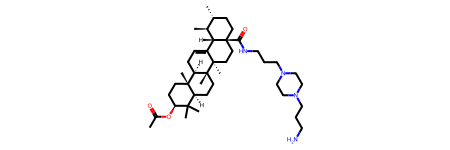

In [52]:
# Draw the molecules with the longest SMILES
longest_smiles_mol = Chem.MolFromSmiles(longest_smiles)
longest_smiles_mol

In [53]:
# Index of the shortest SMILES string
shortest_smiles = min(df6["canonical_smiles"], key=len)
shortest_smiles_index = df6.canonical_smiles[df6.canonical_smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
print(
    f"Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}."
)
# NBVAL_CHECK_OUTPUT

Shortest SMILES: O=c1ccc2c(o1)CCCC2
Contains 18 characters, index in dataframe: 806.


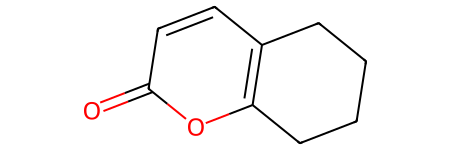

In [54]:
# Draw the molecules with the shortest SMILES
shortest_smiles_mol = Chem.MolFromSmiles(shortest_smiles)
shortest_smiles_mol

 it is common to use standardized values to represent the potency of a molecule. This is done to allow for comparison of molecules with different scales of activity and to facilitate the development of predictive models.

One common way to standardize the potency of a molecule is to use the pIC50 value, which is defined as the negative logarithm (base 10) of the IC50 value (the concentration of a compound that inhibits 50% of a biological activity). The pIC50 value is a commonly used measure of the potency of a compound, as it allows for comparison of compounds with different potencies on the same scale.

In [55]:
df6.to_csv('aromatase3.csv', index=False)

In [2]:
df6 = pd.read_csv('aromatase3.csv')

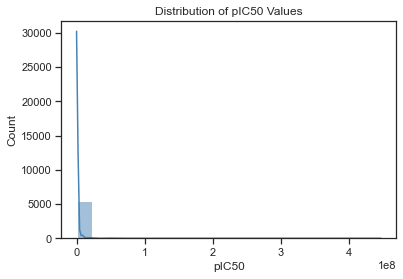

In [59]:
# Visualize the distribution of pIC50 values
sns.histplot(df7['pIC50'], kde=True, bins=20, color='steelblue')
plt.xlabel('pIC50')
plt.ylabel('Count')
plt.title('Distribution of pIC50 Values')
plt.show()

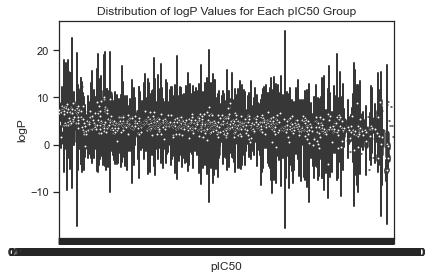

In [60]:
# Create a violin plot of the logP values for each pIC50 group
sns.violinplot(data=df7, x='pIC50', y='LogP', palette='coolwarm')
plt.xlabel('pIC50')
plt.ylabel('logP')
plt.title('Distribution of logP Values for Each pIC50 Group')
plt.show()

We can observe from this plot that there is a trend of increasing LogP values for molecules with lower pIC50 values (i.e., higher potency). This trend suggests that more potent molecules tend to have higher hydrophobicity. However, we can also see that there is a lot of variation in LogP values within each pIC50 group, indicating that hydrophobicity alone is not a sufficient predictor of potency.

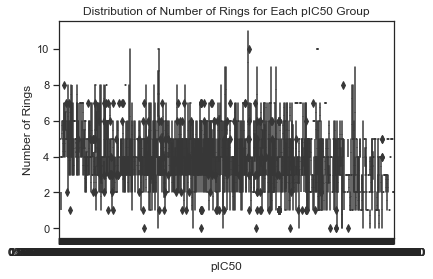

In [61]:
# Create a box plot of the number of rings for each pIC50 group
sns.boxplot(data=df7, x='pIC50', y='num_rings', palette='coolwarm')
plt.xlabel('pIC50')
plt.ylabel('Number of Rings')
plt.title('Distribution of Number of Rings for Each pIC50 Group')
plt.show()


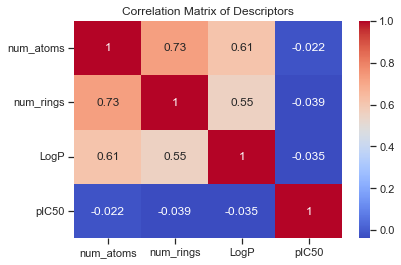

In [62]:
# Create a correlation matrix of the descriptors
corr = df7[['num_atoms', 'num_rings', 'LogP', 'pIC50']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Descriptors')
plt.show()

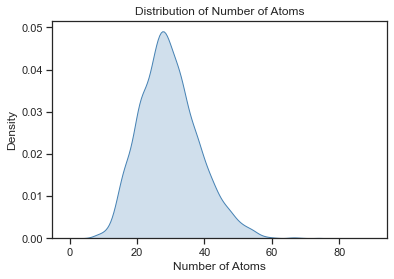

In [63]:
# Visualize the distribution of the number of atoms
sns.kdeplot(df7['num_atoms'], shade=True, color='steelblue')
plt.xlabel('Number of Atoms')
plt.ylabel('Density')
plt.title('Distribution of Number of Atoms')
plt.show()


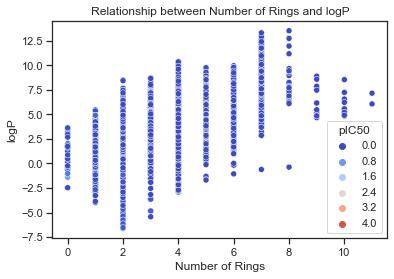

In [64]:
# Create a scatter plot of the logP values vs. the number of rings
sns.scatterplot(data=df7, x='num_rings', y='LogP', hue='pIC50', palette='coolwarm')
plt.xlabel('Number of Rings')
plt.ylabel('logP')
plt.title('Relationship between Number of Rings and logP')
plt.show()

# Outliers 

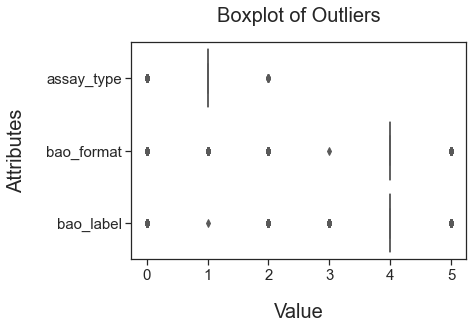

In [68]:
column=[
 
     'assay_type',
       'bao_format', 'bao_label',
       ]
ax = sns.boxplot(data = dfEnco[column], orient = "h", palette = "Set2")
#add labels
ax.set_xlabel("Value", fontsize = 20, labelpad = 20)
ax.set_ylabel("Attributes", fontsize = 20, labelpad = 20)
ax.set_title("Boxplot of Outliers", fontsize = 20,pad = 20)
#edit ticks
ax.tick_params(which = "both", labelsize = 15)

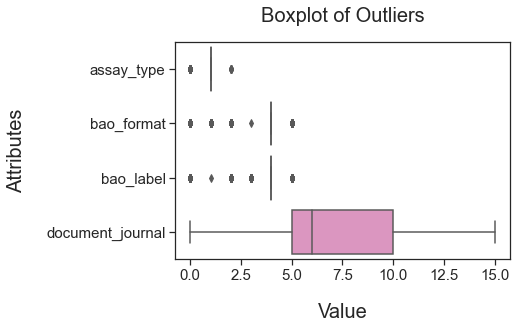

In [69]:
column=[ 'assay_type',
       'bao_format', 'bao_label' ,'document_journal' ]
ax = sns.boxplot(data = dfEnco[column], orient = "h", palette = "Set2")
#add labels
ax.set_xlabel("Value", fontsize = 20, labelpad = 20)
ax.set_ylabel("Attributes", fontsize = 20, labelpad = 20)
ax.set_title("Boxplot of Outliers", fontsize = 20,pad = 20)
#edit ticks
ax.tick_params(which = "both", labelsize = 15)

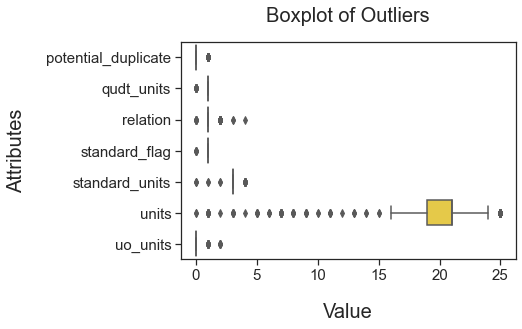

In [70]:
column=['potential_duplicate',
       'qudt_units', 'relation',  'standard_flag',
        'standard_units','units', 'uo_units']
ax = sns.boxplot(data = dfEnco[column], orient = "h", palette = "Set2")
#add labels
ax.set_xlabel("Value", fontsize = 20, labelpad = 20)
ax.set_ylabel("Attributes", fontsize = 20, labelpad = 20)
ax.set_title("Boxplot of Outliers", fontsize = 20,pad = 20)
#edit ticks
ax.tick_params(which = "both", labelsize = 15)

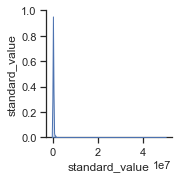

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Select the relevant columns for EDA
cols = ['standard_value']
# Plot pairwise scatterplots for the relevant columns
sns.pairplot(dfEnco[cols], diag_kind='kde')
plt.show()
# Define a function to detect outliers using the IQR method
def detect_outliers_iqr(data, threshold=1.5):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    return ((data < Q1 - threshold*IQR) | (data > Q3 + threshold*IQR))

# Apply the detect_outliers_iqr function to the relevant columns in the DataFrame
outlier_cols =  ['standard_value']
outliers = dfEnco[outlier_cols][detect_outliers_iqr(dfEnco[outlier_cols])]

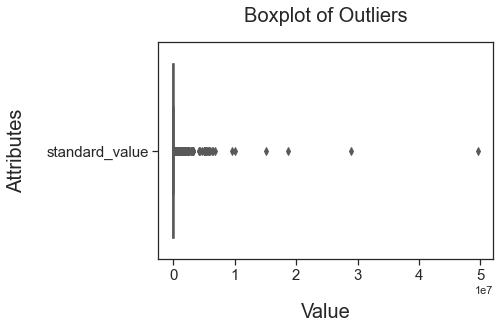

In [72]:
column=['standard_value']
ax = sns.boxplot(data = dfEnco[column], orient = "h", palette = "Set2")
#add labels
ax.set_xlabel("Value", fontsize = 20, labelpad = 20)
ax.set_ylabel("Attributes", fontsize = 20, labelpad = 20)
ax.set_title("Boxplot of Outliers", fontsize = 20,pad = 20)
#edit ticks
ax.tick_params(which = "both", labelsize = 15)

<AxesSubplot:xlabel='standard_value'>

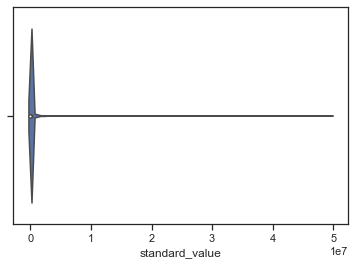

In [73]:
sns.violinplot(x=df['standard_value'])

In [157]:
df8['standard_value']

0         750.0
1         100.0
2       50000.0
3         300.0
4         800.0
         ...   
4429     2440.0
4430     2540.0
4431     3810.0
4432     3460.0
4433     2780.0
Name: standard_value, Length: 4434, dtype: float64

Text(0, 0.5, 'Frequency')

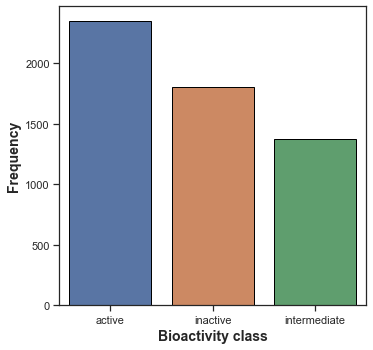

In [156]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='Class', data=df8, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')


Text(0, 0.5, 'pIC50 value')

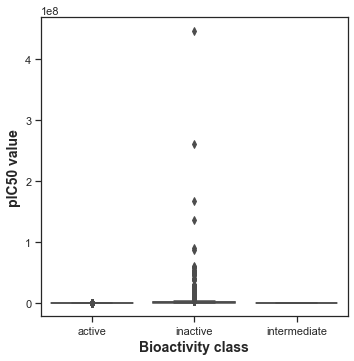

In [77]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'pIC50', data = df8)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')


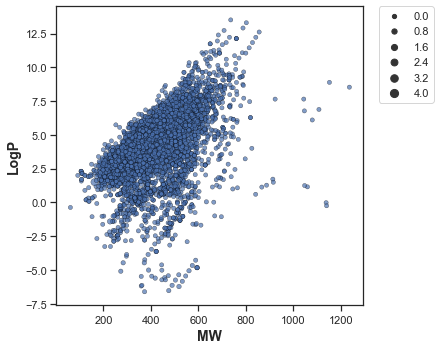

In [78]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df8, size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'MW')

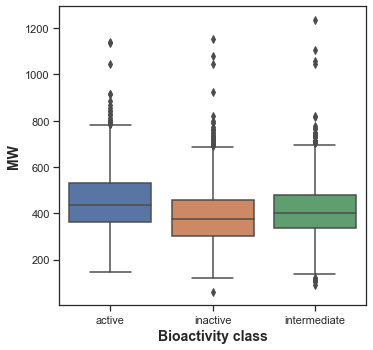

In [79]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'MW', data = df8)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

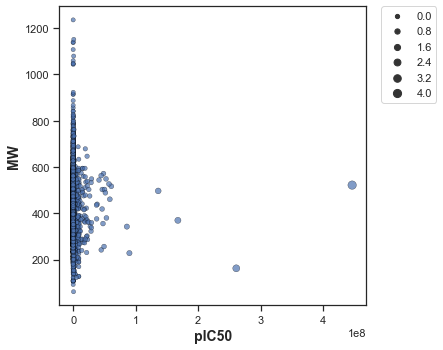

In [80]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='pIC50', y='MW', data=df8, size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('pIC50', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'NumHDonors')

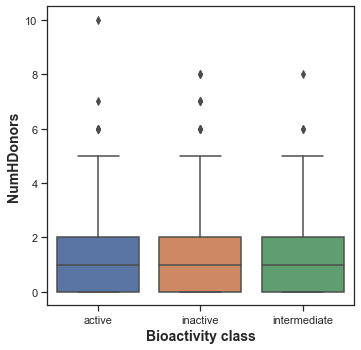

In [81]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'NumHDonors', data = df8)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

In [3]:
df_no_smiles = df6.drop(columns='canonical_smiles')

In [4]:
smiles = []

for i in df6.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [5]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles
0,CHEMBL341591,7100.0,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12
1,CHEMBL2111947,50000.0,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...
2,CHEMBL431859,238.0,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21
3,CHEMBL113637,57.0,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21
4,CHEMBL112021,54.0,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,1002.0,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1
2057,CHEMBL5092560,900.0,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1
2058,CHEMBL5092843,3240.0,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1
2059,CHEMBL5074047,52.0,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1


In [6]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [7]:
-np.log10( (10**-9)* 100000000 )

1.0

In [8]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [9]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [10]:
df_norm = norm_value(df_clean_smiles)
df_norm

C:\Users\houss\AppData\Local\Temp/ipykernel_16612/3416609517.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = input.drop('standard_value', 1)


,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,standard_value_norm
0,CHEMBL341591,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0
1,CHEMBL2111947,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.0
2,CHEMBL431859,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0
3,CHEMBL113637,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0
4,CHEMBL112021,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,1002.0
2057,CHEMBL5092560,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,900.0
2058,CHEMBL5092843,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,3240.0
2059,CHEMBL5074047,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,52.0


In [11]:
df_final = pIC50(df_norm)
df_final

C:\Users\houss\AppData\Local\Temp/ipykernel_16612/3764191868.py:6: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))
C:\Users\houss\AppData\Local\Temp/ipykernel_16612/3764191868.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50
0,CHEMBL341591,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,5.148742
1,CHEMBL2111947,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,4.301030
2,CHEMBL431859,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,6.623423
3,CHEMBL113637,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,7.244125
4,CHEMBL112021,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,7.267606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.999132
2057,CHEMBL5092560,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,6.045757
2058,CHEMBL5092843,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.489455
2059,CHEMBL5074047,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,7.283997


In [12]:
df_final.pIC50.describe()

count    2061.000000
mean             inf
std              NaN
min         3.109579
25%         5.071092
50%         5.902049
75%         6.857861
max              inf
Name: pIC50, dtype: float64

In [13]:
df_final=df_final[df_final['pIC50']<11.2]
df_final

,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50
0,CHEMBL341591,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,5.148742
1,CHEMBL2111947,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,4.301030
2,CHEMBL431859,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,6.623423
3,CHEMBL113637,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,7.244125
4,CHEMBL112021,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,7.267606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,CHEMBL5087363,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.999132
2057,CHEMBL5092560,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,6.045757
2058,CHEMBL5092843,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.489455
2059,CHEMBL5074047,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,7.283997


In [14]:
df_final = df_final.reset_index(drop=True)
df_final

,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50
0,CHEMBL341591,24,5,2,24,5,134,4,4,2,intermediate,329.528,4.28820,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,5.148742
1,CHEMBL2111947,23,5,2,23,5,128,4,4,1,inactive,315.501,3.89810,2.0,2.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,4.301030
2,CHEMBL431859,26,4,5,26,4,132,0,0,4,active,412.306,5.70542,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,6.623423
3,CHEMBL113637,24,4,4,24,4,120,0,0,4,active,319.383,4.63450,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,7.244125
4,CHEMBL112021,23,4,4,23,4,114,0,0,4,active,321.811,4.58780,0.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,7.267606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,CHEMBL5087363,23,3,4,23,3,116,0,0,4,intermediate,306.365,3.81630,2.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.999132
2056,CHEMBL5092560,26,3,3,26,3,132,0,0,6,active,345.442,5.33750,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,6.045757
2057,CHEMBL5092843,25,3,3,25,3,126,0,0,5,intermediate,331.415,4.94740,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,5.489455
2058,CHEMBL5074047,25,3,4,25,3,128,0,0,6,active,334.419,4.66560,3.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x00000122E4D...,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,7.283997


In [15]:
df_final.to_csv('aromatasefinal.csv', index=False)

In [20]:
df_final = pd.read_csv('aromatasefinal.csv')

In [21]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df_final[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [22]:
df_selection

,canonical_smiles,molecule_chembl_id
0,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,CHEMBL341591
1,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,CHEMBL2111947
2,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,CHEMBL431859
3,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL113637
4,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,CHEMBL112021
...,...,...
2055,CC(Cn1ccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL5087363
2056,CCC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL5092560
2057,CC(CCc1cccnc1)=C(c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL5092843
2058,CCC(CCc1c[nH]cn1)=C(c1ccc(O)cc1)c1ccc(O)cc1,CHEMBL5074047


In [23]:
! cat molecule.smi | head -5

CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12	CHEMBL341591
C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43C)[C@@H]1CC[C@@H]2[C@H]1CN1	CHEMBL2111947
CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21	CHEMBL431859
CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21	CHEMBL113637
Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21	CHEMBL112021


## **Download PaDEL-Descriptor**

In [172]:
!C:/wget/wget.exe https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!C:/wget/wget.exe https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-04-20 14:59:35--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-04-20 14:59:36--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: 'padel.zip.1'

     0K .......... .......... .......... .......... ..........  0%  158K 2m39s
    50K .......... .......... .......... .......... ..........  0%  143K 2m47s
   100K .......... .......... ..

--2023-04-20 15:09:44--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2023-04-20 15:09:45--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: 'padel.sh'

     0K                                                       100% 3.33M=0s

2023-04-20 15:09:45 (3.33 MB/s) - 'padel.sh' saved [231/231]



In [ ]:
! unzip padel.zip

## **Calculate fingerprint descriptors**


In [10]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [24]:
! bash padel.sh

Processing CHEMBL341591 in molecule.smi (1/2060). 
Processing CHEMBL2111947 in molecule.smi (2/2060). 
Processing CHEMBL431859 in molecule.smi (3/2060). 
Processing CHEMBL112021 in molecule.smi (5/2060). 
Processing CHEMBL113637 in molecule.smi (4/2060). 
Processing CHEMBL324070 in molecule.smi (6/2060). 
Processing CHEMBL111868 in molecule.smi (8/2060). 
Processing CHEMBL41761 in molecule.smi (7/2060). 
Processing CHEMBL112074 in molecule.smi (10/2060). Average speed: 1.46 s/mol.
Processing CHEMBL324326 in molecule.smi (11/2060). Average speed: 1.48 s/mol.
Processing CHEMBL111888 in molecule.smi (9/2060). Average speed: 2.91 s/mol.
Processing CHEMBL37321 in molecule.smi (12/2060). Average speed: 1.01 s/mol.
Processing CHEMBL353068 in molecule.smi (13/2060). Average speed: 0.81 s/mol.
Processing CHEMBL41066 in molecule.smi (14/2060). Average speed: 0.59 s/mol.
Processing CHEMBL166709 in molecule.smi (15/2060). Average speed: 0.61 s/mol.
Processing CHEMBL424556 in molecule.smi (16/2060)

Processing CHEMBL70317 in molecule.smi (165/2060). Average speed: 0.10 s/mol.
Processing CHEMBL307690 in molecule.smi (166/2060). Average speed: 0.10 s/mol.
Processing CHEMBL73279 in molecule.smi (167/2060). Average speed: 0.10 s/mol.
Processing CHEMBL69891 in molecule.smi (168/2060). Average speed: 0.10 s/mol.
Processing CHEMBL72056 in molecule.smi (169/2060). Average speed: 0.10 s/mol.
Processing CHEMBL307643 in molecule.smi (170/2060). Average speed: 0.10 s/mol.
Processing CHEMBL310735 in molecule.smi (171/2060). Average speed: 0.10 s/mol.
Processing CHEMBL73368 in molecule.smi (172/2060). Average speed: 0.10 s/mol.
Processing CHEMBL308537 in molecule.smi (173/2060). Average speed: 0.10 s/mol.
Processing CHEMBL307581 in molecule.smi (174/2060). Average speed: 0.10 s/mol.
Processing CHEMBL70959 in molecule.smi (175/2060). Average speed: 0.10 s/mol.
Processing CHEMBL305205 in molecule.smi (176/2060). Average speed: 0.10 s/mol.
Processing CHEMBL73071 in molecule.smi (177/2060). Average

## **Preparing the X and Y Data Matrices**

In [27]:
df_x = pd.read_csv('descriptors_output.csv')

In [28]:
df_x

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL111868,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL41761,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL112021,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL431859,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL113637,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,CHEMBL5087363,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2056,CHEMBL5092560,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2057,CHEMBL5074047,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2058,CHEMBL5092843,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_x = df_x.drop(columns=['Name'])
df_x

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2056,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2057,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2058,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_class=df_final['Class']

In [31]:
df_y = df_final['pIC50']
df_y

0       5.148742
1       4.301030
2       6.623423
3       7.244125
4       7.267606
          ...   
2055    5.999132
2056    6.045757
2057    5.489455
2058    7.283997
2059    7.200659
Name: pIC50, Length: 2060, dtype: float64

In [32]:
dataset = pd.concat([df_x,df_y], axis=1)
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.148742
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.623423
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.244125
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.267606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.999132
2056,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.045757
2057,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.489455
2058,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.283997


In [33]:
dataset2 = pd.concat([dataset,df_class], axis=1)

In [34]:
dataset2

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50,Class
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.148742,intermediate
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4.301030,inactive
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.623423,active
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.244125,active
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.267606,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.999132,intermediate
2056,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.045757,active
2057,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,5.489455,intermediate
2058,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.283997,active


In [35]:
df_2class = dataset2[dataset2['Class'] != 'intermediate']
df_2class

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50,Class
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4.301030,inactive
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.623423,active
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.244125,active
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.267606,active
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.387216,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.064997,active
2054,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.455932,active
2056,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6.045757,active
2058,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,7.283997,active


In [36]:
df8=df_2class

In [37]:
Y_p=df_2class['pIC50']
Y_p

1       4.301030
2       6.623423
3       7.244125
4       7.267606
6       7.387216
          ...   
2053    6.064997
2054    7.455932
2056    6.045757
2058    7.283997
2059    7.200659
Name: pIC50, Length: 1458, dtype: float64

In [38]:
Y_c = df_2class['Class']
Y_c

1       inactive
2         active
3         active
4         active
6         active
          ...   
2053      active
2054      active
2056      active
2058      active
2059      active
Name: Class, Length: 1458, dtype: object

In [39]:
X = df_2class.drop(columns=['pIC50','Class'])
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2054,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2056,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2058,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# ### **3.4. Remove low variance features**

In [40]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(X, threshold=0.1)
X

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP33,PubchemFP143,...,PubchemFP776,PubchemFP777,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP860
1,1,1,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2054,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2056,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2058,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [41]:
X.to_csv('descriptor_list3.csv', index = False)

In [42]:
X.to_csv('descriptor_list4.csv', index = False)

## **4. Data split (80/20 ratio)**

In [43]:
from sklearn.model_selection import train_test_split


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_p, test_size=0.2, random_state=42)

In [45]:
X_train.shape

(1166, 249)

In [46]:
Y_train.shape

(1166,)

In [47]:
X_test.shape

(292, 249)

In [48]:
X_test

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP33,PubchemFP143,...,PubchemFP776,PubchemFP777,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP860
1826,0,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1169,1,1,1,1,0,1,1,1,0,1,...,0,1,0,0,0,1,0,1,0,0
613,0,1,1,1,1,1,1,1,0,1,...,0,1,1,0,0,1,0,1,0,0
755,0,1,0,0,0,1,1,0,0,0,...,1,1,0,1,1,0,1,1,0,0
1424,1,1,1,1,0,1,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,1,1,0,0,0,1,1,1,0,0,...,0,1,0,1,0,1,0,1,0,0
1914,0,1,1,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2002,0,1,1,1,0,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
947,1,1,1,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [49]:
Y_test.shape

(292,)

## **Modeling** Regression

In [50]:
from lightgbm import LGBMRegressor

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet, Lars, BayesianRidge, SGDRegressor, PassiveAggressiveRegressor, RANSACRegressor, HuberRegressor, OrthogonalMatchingPursuit, ARDRegression, TheilSenRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSCanonical, PLSRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import GammaRegressor, PoissonRegressor, TweedieRegressor


In [53]:
DTRmodel = DecisionTreeRegressor()
DTRmodel.fit(X_train, Y_train)
sc = DTRmodel.score(X_test, Y_test)
sc

0.11022695697242779

In [54]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.3557315912426069

In [55]:
BRmodel = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)
BRmodel.fit(X_train, Y_train)
sc = BRmodel.score(X_train, Y_train)
sc

0.77896142651228

In [56]:
Y_pred = BRmodel.predict(X)
Y_pred

array([5.98334858, 6.82543559, 6.62675975, ..., 6.5518989 , 6.5518989 ,
       6.91765103])

In [57]:
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_p, Y_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_p, Y_pred))

Mean squared error (MSE): 0.67
Coefficient of determination (R^2): 0.69


Text(0.5, 0, 'Experimental pIC50')

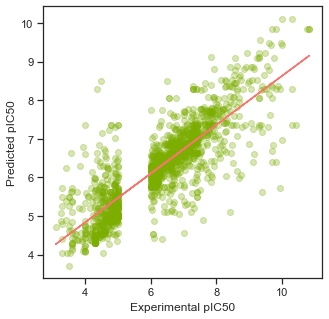

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(x=Y_p, y=Y_pred, c="#7CAE00", alpha=0.3)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_p, Y_pred, 1)
p = np.poly1d(z)

plt.plot(Y_p,p(Y_p),"#F8766D")
plt.ylabel('Predicted pIC50')
plt.xlabel('Experimental pIC50')

In [59]:
import pickle

In [60]:
pickle.dump(BRmodel, open('aromatase_model1.pkl', 'wb'))

## **Modeling** classification 

In [61]:
X

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP33,PubchemFP143,...,PubchemFP776,PubchemFP777,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP860
1,1,1,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2054,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2056,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2058,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_c, test_size=0.2, random_state=42)

In [63]:
from sklearn import svm, tree, naive_bayes, ensemble , neighbors
# List of different Machine learning Algorithm we will use 
MLA = [
    ensemble.RandomForestClassifier(random_state=0),
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    #Trees    
    tree.DecisionTreeClassifier(random_state=0),
    tree.ExtraTreeClassifier(random_state=0),
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    #SVM
    svm.LinearSVC(random_state=0), 
    svm.NuSVC(probability=True),
    svm.SVC(probability=True) 
    ]
from sklearn.metrics import accuracy_score


In [66]:
MLA_columns = ['MLA Name', 'MLA Test Accuracy' ]
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    alg.fit(x_train, y_train)

    alg_acc = accuracy_score(y_test, alg.predict(x_test))
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = alg_acc

   
    
    row_index+=1

    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)
MLA_compare

C:\Users\houss\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,MLA Name,MLA Test Accuracy
0,RandomForestClassifier,0.756849
7,NuSVC,0.756849
6,LinearSVC,0.75
5,KNeighborsClassifier,0.746575
8,SVC,0.746575
3,DecisionTreeClassifier,0.739726
4,ExtraTreeClassifier,0.715753
2,GaussianNB,0.59589
1,BernoulliNB,0.571918


In [67]:
Tree=ensemble.RandomForestClassifier(random_state=0)
Tree.fit(x_train, y_train)
alg_acc = accuracy_score(y_test, Tree.predict(x_test))
alg_acc

0.7568493150684932

In [68]:
X

,PubchemFP2,PubchemFP12,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP33,PubchemFP143,...,PubchemFP776,PubchemFP777,PubchemFP779,PubchemFP797,PubchemFP798,PubchemFP803,PubchemFP818,PubchemFP819,PubchemFP821,PubchemFP860
1,1,1,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2054,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2056,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2058,1,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [70]:
Y_pred1 = Tree.predict(X)
Y_pred1

array(['inactive', 'active', 'active', ..., 'active', 'active', 'active'],
      dtype=object)

In [440]:
Y_c

0         active
1         active
2       inactive
3         active
4         active
          ...   
5591      active
5592      active
5593      active
5594      active
5595      active
Name: Class, Length: 4209, dtype: object

In [442]:
pickle.dump(Tree, open('aromatase_model2.pkl', 'wb'))